In [2]:
''' importing libraries '''

import os, subprocess
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import datetime

from pylab import figtext

## -----------------------------------

plt.style.use('seaborn')
 
## -----------------------------------
 
path_out_figs = "/home/brotzer/notebooks/figs/"
    
path_scripts = '/home/brotzer/Documents/scripts/'

path_data = '/home/brotzer/spyder/data/'

path_mjd = '/import/freenas-ffb-01-data/romy_status/'

## -----------------------------------´


## assigment of ring names
ring={1:'Z-Ring',2:'W-Ring',3:'N-Ring',4:'E-Ring'}


' importing libraries '

In [35]:
def get_data2(path_name,file_name): 
    ''' 
    Method to retrieve data from log-file and store it as dataframe 

    
    Dependencies: 
     --> import os 
     --> import pandas as pd
    '''
   
    ## try to find and read mjd-files of ROMY
    if os.path.exists(path_name+file_name):
        
        df=pd.read_csv(path_name+file_name, delimiter=' ', names=['year','doy','size','linenum','filename'])
    else:
        print('\n!!! ERROR IMPORTING!!! \n \n--> Possibliy file does not exist?!   {}\n'.format(path_name+file_name))
        return
    
    ## print file name 
    print('\n reading   {} ... \n'.format(file_name))    
        
    ## print top of file 
    print(df.head(2))
    print(df.tail(2))
    
    ## print number of rows
    rows,cols=df.shape
    print('\n number of rows: {} \n number of columns: {} \n'.format(rows,cols))
    
    return df

In [4]:
def save_to_pdf(figs, outpath, outname):
    ''' 
    Saving figures in array figs continously to pdf-file
    
    ''' 
    
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages("{}{}.pdf".format(outpath,outname))
    
    for f in figs: 
        pdf.savefig( f )
    pdf.close()
    


In [5]:
def get_beagle_year(path_data,bg_in,yr_in):

    ## read the required modified mjd files 
    df = get_data2('','{}beagle_{}_mjd_files.dat'.format(path_data,bg_in))

    ## extract only required year
    df_year = df[df['year']==int(yr_in)]

    ## project on same doy
    df_year_new = df_year.groupby(df_year['doy'], as_index=False).aggregate({'year': 'first', 'size': 'sum', 'linenum': 'sum', 'filename': 'first'})

    return df_year_new


def get_allrings_up(yr_in):
      
    d01 = get_beagle_year(path_data,'01',yr_in)
    d02 = get_beagle_year(path_data,'02',yr_in)
    d03 = get_beagle_year(path_data,'03',yr_in)
    d04 = get_beagle_year(path_data,'04',yr_in)
    

    merged_12   = pd.merge(d01[['year', 'doy','linenum']], d02[['doy','linenum']], on="doy", how='inner')
    merged_123  = pd.merge(merged_12, d03[['doy','linenum']], on="doy", how='inner')
    merged_1234 = pd.merge(merged_123, d04[['doy','linenum']], on="doy", how='inner')

    merged_1234.columns = ['year','doy','Z','V','U','W']; 

    all_rings_yr = merged_1234[(merged_1234 != 0).all(1)]

    ## add column with uptime of all rings
    all_rings_yr['all'] = all_rings_yr.apply(lambda row: (row.Z + row.U + row.V +row.W)/4,axis=1)

    del merged_12, merged_123, merged_1234
    
    return all_rings_yr


In [33]:

def makeplot_yearbars(yrs,mnt):
        
    plt.style.use('seaborn')

    fig, ax = plt.subplots()
    
    ax.bar(yrs,mnt, width=0.5, color='green', alpha=0.6)
    
    ax.set_xticks(yrs)
    ax.set_title('days when all rings were running simultaneously')
    ax.set_ylim(0,max(mnt)+15)   
    
        
    for i,j in zip(yrs,mnt):
        ax.text(i,j+2,"{}".format(j),ha='center',color='black',fontsize=12)
        

In [6]:

def makeplot_polar_uptime(data,year,comp='all'):
    ''' 
    polar plots of uptime of all rings 
    
    '''
    data = data[ data['year'] == year ]
     
    data1 = data[ data['linenum'] == 86400 ]
    data2 = data[ data['linenum'] <  86400 ]
    
    months=np.array([0,31,28,31,30,31,30,31,31,30,31,30]).cumsum()
#    monthnames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    monthnames = ['Jan\n(0)','Feb\n(31)','Mar\n(59)','Apr\n(90)','May\n(120)','Jun\n(151)','Jul\n(181)','Aug\n(212)','Sep\n(243)','Oct\n(273)','Nov\n(304)','Dec\n(334)']


#    months2 = np.array([0,15,31,46,59,74,90,105,120,135,151,166,181,196,212,227,243,258,273,288,304,319,334,349])
#    monthnames2 = ['0','Jan','31','Feb','59','Mar','90','Apr', '120','May','151','Jun', '181','Jul', '212','Aug', '243','Sep','273','Oct', '304','Nov', '334','Dec']


    xtext = np.array([15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])/365*2*np.pi
    ytext = np.ones(len(xtext))*110
                  
    ## -------------------------------------------------------------------
    ## plot single years as polar plots
    
    plt.style.use('seaborn')

    fig = plt.figure(figsize=(10,10))
    
    ax = plt.subplot(111, projection='polar')
    ax.set(aspect=1)
    

    ## plot the bars 
    #bars = ax.bar(data['doy']/365*2*np.pi, data[comp]/86400*100, label=str(comp), width=0.01, color='green', alpha=1.0)
    
    bars1 = ax.bar(data1['doy']/365*2*np.pi, data1[comp]/86400*100, label=str(comp), width=0.01, color='darkgreen', alpha=1.0)
    bars2 = ax.bar(data2['doy']/365*2*np.pi, data2[comp]/86400*100, label=str(comp), width=0.01, color='yellowgreen', alpha=1.0)

    
    ## adjust the ticks and ticklabels to doy or months
    ax.set_xticks(months/365*2*np.pi)
    ax.set_xticklabels(monthnames)
    ax.set_rlabel_position(359)
    ax.set_yticks([20,40,60,80])
    ax.set_yticklabels(['20%','40%','60%','80%'])
    ax.set_rlim(0,100)

    
    ## set title adaptively
    if comp == 'all' :
        ax.set_title('combined uptime on days with all 4 rings operating in {}'.format(year))
    elif comp == 'linenum' :
        ax.set_title('Uptime of all 4 rings operating simultaneously in {}'.format(year))
    else:
        ax.set_title('uptime of {} component on days with all 4 rings operating in {}'.format(comp,year))

    
    # for x,y,mname in zip(xtext,ytext,monthnames):
    #     ax.text(x,y,mname)
    
    ## Make the labels go clockwise
    ax.set_theta_direction(-1)       
    
    ## Place 0 at the top
    ax.set_theta_offset(np.pi/2.0)   
    
    
    ## save the figure to a pdf
    save_to_pdf([fig], path_out_figs, 'ROMY_{}_AllRingsUp'.format(year))



In [7]:
## get merged data for one year with only those days of all 4 rings running  at least partly

all_rings_2017 = get_allrings_up(2017)
all_rings_2018 = get_allrings_up(2018)
all_rings_2019 = get_allrings_up(2019)
all_rings_2020 = get_allrings_up(2020)


## create polar plots 

# makeplot_polar_uptime(all_rings_2017,2017,comp='all')        
# makeplot_polar_uptime(all_rings_2018,2018,comp='all')        
# makeplot_polar_uptime(all_rings_2019,2019,comp='all')       


 reading   /home/brotzer/spyder/data/beagle_01_mjd_files.dat ... 

   year  doy  size  linenum  filename
0  2017  152   467     1079       NaN
1  2017  153  1190     1060       NaN
     year  doy  size  linenum  filename
801  2020  168     4       38       NaN
802  2020  171     4       71       NaN

 number of rows: 803 
 number of columns: 5 


 reading   /home/brotzer/spyder/data/beagle_02_mjd_files.dat ... 

   year  doy  size  linenum  filename
0  2017  218   413    34643       NaN
1  2017  219  1016    85157       NaN
     year  doy  size  linenum  filename
611  2020  170   282       22       NaN
612  2020  171    11        0       NaN

 number of rows: 613 
 number of columns: 5 


 reading   /home/brotzer/spyder/data/beagle_03_mjd_files.dat ... 

   year  doy  size  linenum  filename
0  2017  219   666    53745       NaN
1  2017  220  1034    86398       NaN
     year  doy  size  linenum  filename
647  2020  171     4       67       NaN
648  2020  176     4       62       NaN


/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brotzer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [8]:
''' Export overlapping DoYs to files'''

all_rings_2017['doy'].to_csv('/home/brotzer/notebooks/data/overlap_2017.txt',index=False,header=None)
all_rings_2018['doy'].to_csv('/home/brotzer/notebooks/data/overlap_2018.txt',index=False,header=None)
all_rings_2019['doy'].to_csv('/home/brotzer/notebooks/data/overlap_2019.txt',index=False,header=None)
all_rings_2020['doy'].to_csv('/home/brotzer/notebooks/data/overlap_2020.txt',index=False,header=None)

''' create data.dat file with simultanous run times for DoYs '''
## Merging is easier and more efficient using bash command join than my attempts to implement it in python. 
## Therefore a bash script is called!


#import subprocess
#subprocess.check_call(['/home/brotzer/bin/overlap.sh', ], shell=True)

## or 

# %%bash
# /home/brotzer/bin/overlap.sh 


' Export overlapping DoYs to files'

' create data.dat file with simultanous run times for DoYs '

' plot annual simultaneous uptime of all rings'

' plot simple comparison of years as bar plot '

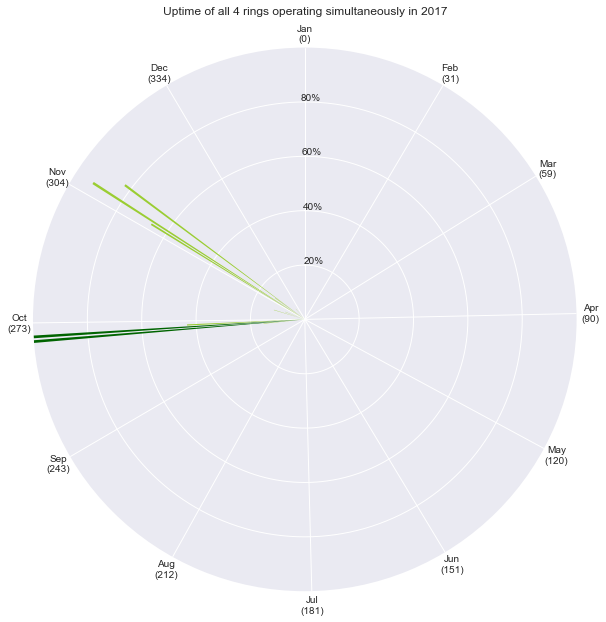

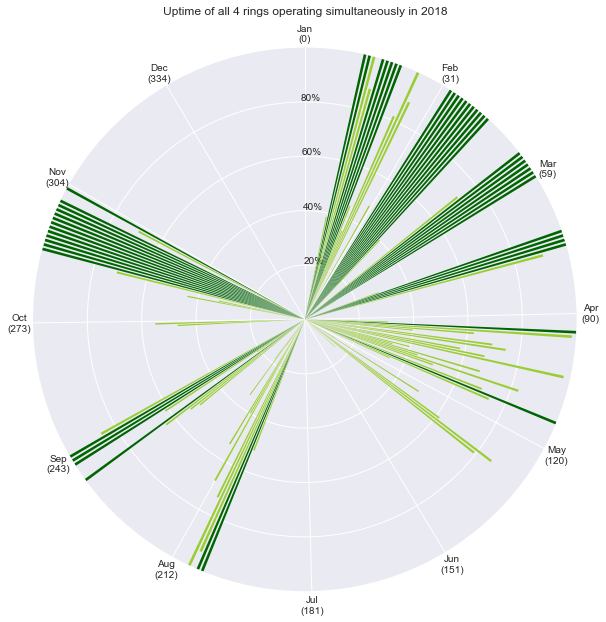

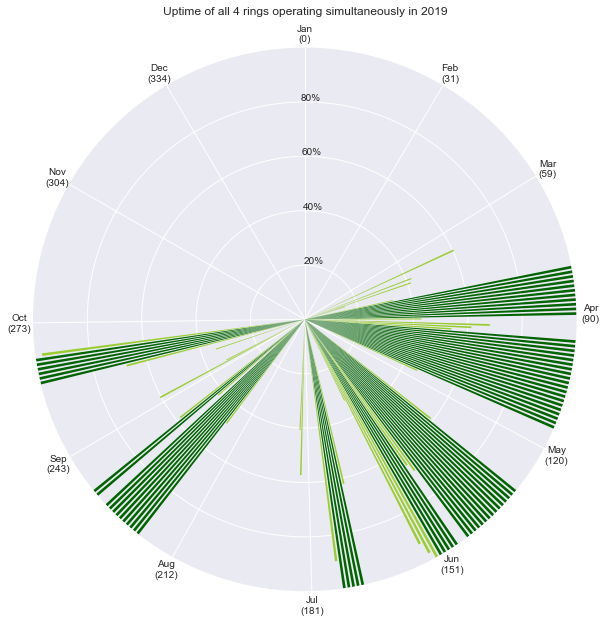

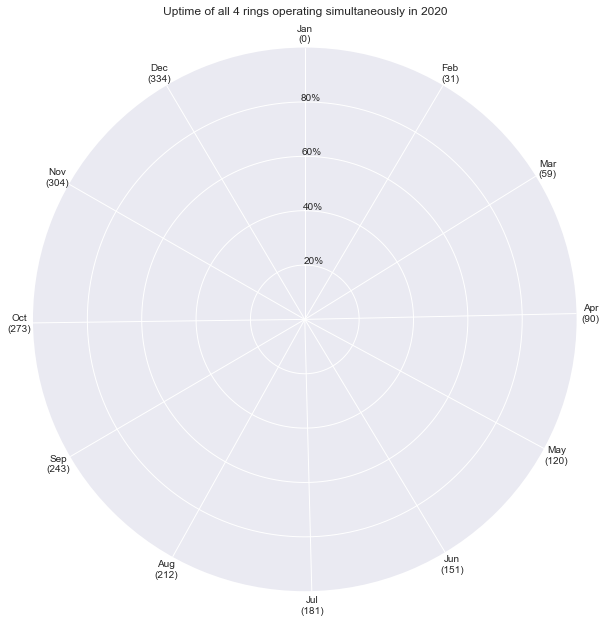

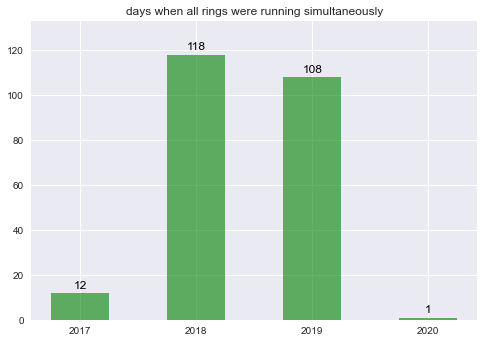

In [34]:
''' plot annual simultaneous uptime of all rings'''

path     = '/home/brotzer/notebooks/data/'
filename = 'data_simultaneous_uptime.dat'

df=pd.read_csv(path+filename, delimiter=' ', names=['year','doy','linenum','loc'])

makeplot_polar_uptime(df,2017,comp='linenum')       
makeplot_polar_uptime(df,2018,comp='linenum')       
makeplot_polar_uptime(df,2019,comp='linenum')       
makeplot_polar_uptime(df,2020,comp='linenum')   



''' plot simple comparison of years as bar plot '''

amount = []
years  = [2017, 2018, 2019, 2020]

for year in years:
    num = df[ (df['year'] == year) & (df['linenum'] != 0) ].count()
    amount.append(num['linenum'])

makeplot_yearbars(years,amount)

